## Libraries

In [0]:
from copy import copy
import numpy as np 
from numpy import exp, log
import pandas as pd 
import os


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)




# Simulation Data

### Simulate inputs for 3 channels, constant 2 time steps, 100K observations

In [0]:
channels = ['facebook', 'google', 'snapchat']
num_chnls = len(channels)
N = 100000

np.random.seed(498)
df = pd.DataFrame({'t1':np.random.uniform(-.5,num_chnls-.5,N)
                   , 't2':np.random.uniform(-.5,num_chnls-.5,N)
                   , 't3':np.random.uniform(-.5,num_chnls-.5,N)})

df['t1'] = df['t1'].apply(lambda x: int(round(x)))
df['t2'] = df['t2'].apply(lambda x: int(round(x)))
df['t3'] = df['t3'].apply(lambda x: int(round(x)))

#np.random.seed(1)
df['gap1'] = np.random.gamma(1.2, 1.2, N)
#np.random.seed(2)
df['gap2'] = np.random.gamma(1.2, 1.2, N)
df['gap1'] = df['gap1'] + df['gap2']
#np.random.seed(3)
df['gender'] = np.random.binomial(1, .4, N)


(array([684., 142.,  87.,  40.,  17.,  13.,   5.,   6.,   3.,   3.]),
 array([6.62376023e-08, 2.34107815e-01, 4.68215563e-01, 7.02323311e-01,
        9.36431060e-01, 1.17053881e+00, 1.40464656e+00, 1.63875430e+00,
        1.87286205e+00, 2.10696980e+00, 2.34107755e+00]),
 <BarContainer object of 10 artists>)

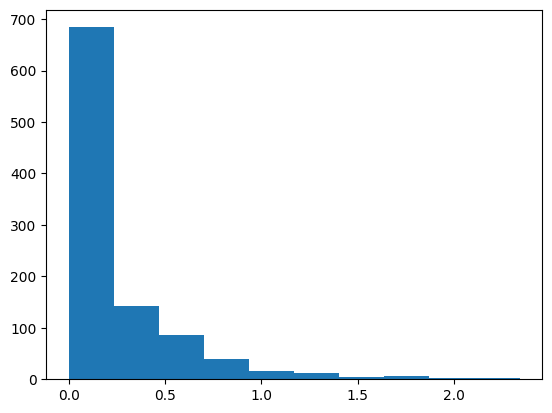

In [0]:
plt.hist(np.random.gamma(.5, .5, 1000))

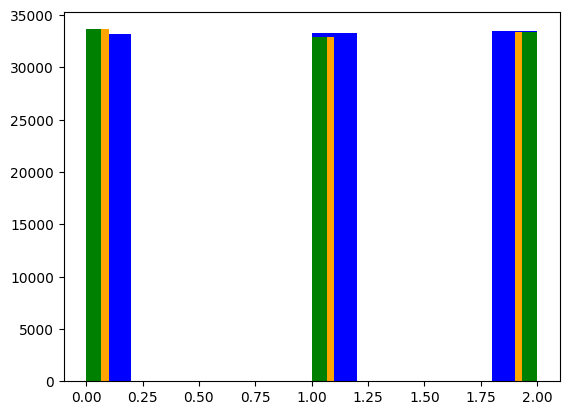

In [0]:
_=plt.hist(df['t1'], bins=10, color='blue')
_=plt.hist(df['t2'], bins=20, color='orange')
_=plt.hist(df['t2'], bins=30, color='green')

### Parameter Assignment

In [0]:

v0 = -3 #intercept, negative since most people don't convert
beta_g0 = 1.7 #google effect when it is first time step is stronger than otherwise
beta_g1 = .8 #google effect when it is second time step
beta_f0 = .9 #facebook effect when it is first time step 
beta_f1 = 1.5 #facebook effect when it is second time step
beta_s0 = .7 #snapchat effect when it is first time step
beta_s1 = .5 #snapchat effect when it is first time step
beta_last_tch = 1 #effect boosted when channel is last touched, constant for all channels
beta_gender = .4 #effect for gender 
alpha = -1.2 #decay effect for gap between time steps, constant for all channels
c = 1 #constant to prevent exploding gap terms when they are <1


In [0]:

v0 = -2.5#-abs(np.random.normal(3, .5, 1))[0] #intercept, negative since most people don't convert
beta_g0 = abs(np.random.normal(1.2, .3, 1))[0] #google effect when it is first time step is stronger than otherwise
beta_g1 = abs(np.random.normal(.8, .4, 1))[0] #google effect when it is second time step
beta_f0 = abs(np.random.normal(1, .5, 1))[0] #facebook effect when it is first time step 
beta_f1 = abs(np.random.normal(1.1, .5, 1))[0] #facebook effect when it is second time step
beta_s0 = abs(np.random.normal(1, .6, 1))[0] #snapchat effect when it is first time step
beta_s1 = abs(np.random.normal(1, .6, 1))[0] #snapchat effect when it is first time step
beta_last_tch = abs(np.random.normal(1, .1, 1))[0] #effect boosted when channel is last touched, constant for all channels
beta_gender = abs(np.random.normal(.5, .2, 1))[0] #effect for gender 
alpha = -abs(np.random.normal(1, 1, 1))[0] #decay effect for gap between time steps, constant for all channels
c = 1 #constant to prevent exploding gap terms when they are <1


In [0]:
v0

-2.5

In [0]:
print('v0:', round(v0, 3))
print('beta_g:', [round(beta_g0, 3), round(beta_g1, 3)])
print('beta_f:', [round(beta_f0, 3), round(beta_f1, 3)])
print('beta_s:', [round(beta_s0, 3), round(beta_s1, 3)])
print('beta_last_tch:', round(beta_last_tch, 3))
print('beta_gender:', round(beta_gender, 3))
print('alpha:', round(alpha, 3))

v0: -2.5
beta_g: [1.335, 0.644]
beta_f: [0.182, 1.222]
beta_s: [1.484, 1.061]
beta_last_tch: 0.882
beta_gender: 0.48
alpha: -1.184



### Logistic Data Generating Function

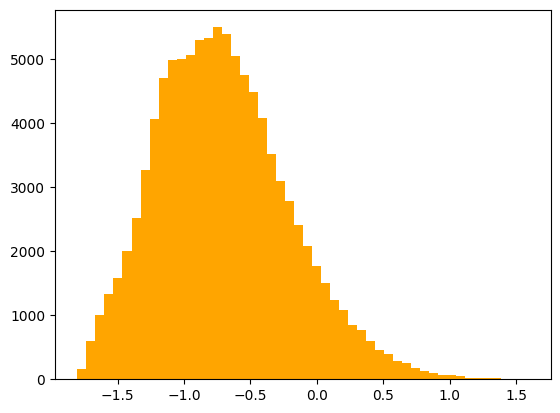

In [0]:

y = v0 + beta_f0*(df['t1']==0)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t2']==0)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t3']==0)*beta_last_tch +\
beta_g0*(df['t1']==1)*df['gap1'].apply(lambda x: (x+c)**alpha) +  beta_g1*(df['t2']==1)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_g1*(df['t3']==1) +\
beta_s0*(df['t1']==2)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t2']==2)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t3']==2)*beta_last_tch +\
beta_gender*df['gender']

plt.hist(y, bins=50, color='orange')
df['y'] = y 


z = 1/(1+exp(-y))
df['z'] = z 


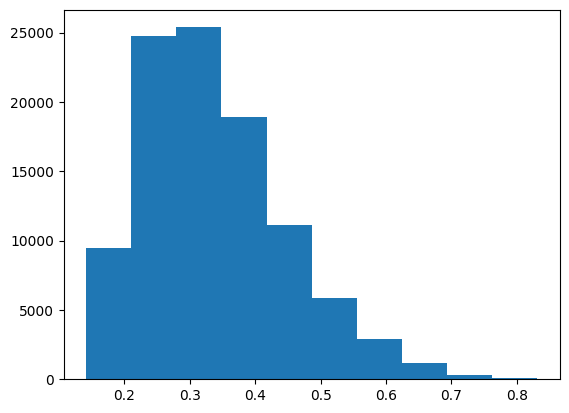

In [0]:
_=plt.hist(df['z'])

In [0]:

# Conversion based on binomial random variable with probability_conversion_i = z_i
df['conversion'] = df.apply(lambda x: np.random.binomial(1, x['z'], 1), axis=1)
df['conversion']= df['conversion'].astype(int)


#### Distribution of P(conversion) and **conversion**

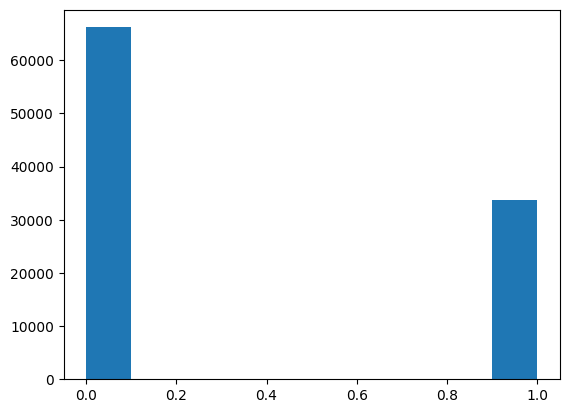

In [0]:
_=plt.hist(df['conversion'])


#### Create columns for the calculated contribution of each channel

In [0]:

df['cont_unscaled_fb'] = beta_f0*(df['t1']==0)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t2']==0)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_f1*(df['t3']==0)*beta_last_tch 

df['cont_unscaled_gg'] = beta_g0*(df['t1']==1)*df['gap1'].apply(lambda x: (x+c)**alpha) +  beta_g1*(df['t2']==1)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_g1*(df['t3']==1) 
    
df['cont_unscaled_sp'] = beta_s0*(df['t1']==2)*df['gap1'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t2']==2)*df['gap2'].apply(lambda x: (x+c)**alpha) + beta_s1*(df['t3']==2)*beta_last_tch 


df['cont_fb'] = df['cont_unscaled_fb']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])
df['cont_gg'] = df['cont_unscaled_gg']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])
df['cont_sp'] = df['cont_unscaled_sp']/(df['cont_unscaled_fb'] + df['cont_unscaled_gg'] + df['cont_unscaled_sp'])


#### View of sample of the dataframe

In [0]:
df[['t1', 't2', 't3', 'gap1',  'gap2', 'gender','y','z', 'conversion', 'cont_unscaled_fb','cont_unscaled_gg','cont_unscaled_sp', 'cont_fb', 'cont_gg', 'cont_sp']].sample(10)


,t1,t2,t3,gap1,gap2,gender,y,z,conversion,cont_unscaled_fb,cont_unscaled_gg,cont_unscaled_sp,cont_fb,cont_gg,cont_sp
98587,0,0,0,0.494205,0.389269,1,-0.001717,0.499571,0,2.018229,0.000000,0.000000,1.000000,0.000000,0.000000
10957,2,1,1,2.005763,1.110057,0,-1.187487,0.233709,0,0.000000,0.909478,0.403036,0.000000,0.692928,0.307072
67078,0,1,2,0.287110,0.042766,0,-0.816297,0.306550,0,0.135026,0.612520,0.936157,0.080196,0.363793,0.556011
81728,1,1,2,5.253753,1.344817,0,-1.177059,0.235581,0,0.000000,0.386783,0.936157,0.000000,0.292366,0.707634
75705,1,0,0,3.973866,2.887066,1,-0.498178,0.377969,0,1.322162,0.199606,0.000000,0.868833,0.131167,0.000000
8798,1,2,2,1.958507,0.134423,0,-0.280437,0.430347,1,0.000000,0.369312,1.850251,0.000000,0.166389,0.833611
17485,2,1,1,3.698210,3.593059,0,-1.513069,0.180484,0,0.000000,0.749465,0.237466,0.000000,0.759390,0.240610
2864,2,1,2,4.150496,2.973459,1,-0.745206,0.321867,1,0.000000,0.125609,1.149130,0.000000,0.098537,0.901463
71880,1,1,1,6.592445,3.243696,0,-1.619189,0.165317,1,0.000000,0.880811,0.000000,0.000000,1.000000,0.000000
70275,2,1,1,4.101425,3.406026,0,-1.529793,0.178024,0,0.000000,0.754805,0.215402,0.000000,0.777984,0.222016


## Format Data for Input

In [0]:
num_time_steps = 3
num_cats = 3
num_feats = 2

### Train Test Split / Split into Numerical and Categorical Matrices / Reshape 

In [0]:
df['gap3'] = 0 #create an extra gap column for time step 2 which is always 0 since there is no time step 3 in this simulation
df['gender_t2'] = df['gender'] #create an extra gender column for time step 2 which is the same as gender
df['gender_t3'] = df['gender'] #create an extra gender column for time step 2 which is the same as gender
df['log_gap1'] = log(df['gap1'])
df['log_gap2'] = log(df['gap2'])
df['log_gap3'] = 0

X = df[['t1', 't2','t3','gender', 'gap1','log_gap1', 'gender_t2', 'gap2','log_gap2', 'gender_t3', 'gap3','log_gap3', 'z']]
y = np.array(df['conversion'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

#Split X_train into numerical and categorical matrices for separate input into the model
#X_train_num = np.array(X_train[['gender', 'gap1','log_gap1', 'gender_t2','gap2', 'log_gap2', 'gender_t3','gap3', 'log_gap3']]) #gender is time-invariant so the same for both time steps
#X_test_num = np.array(X_test[['gender', 'gap1','log_gap1', 'gender_t2','gap2', 'log_gap2', 'gender_t3','gap3', 'log_gap3']])
X_train_num = np.array(X_train[['gender','log_gap1', 'gender_t2', 'log_gap2', 'gender_t3', 'log_gap3']]) #gender is time-invariant so the same for both time steps
X_test_num = np.array(X_test[['gender','log_gap1', 'gender_t2', 'log_gap2', 'gender_t3', 'log_gap3']])

X_train_num2 = np.reshape(X_train_num, (len(X_train_num),num_time_steps, num_feats))
X_test_num2 = np.reshape(X_test_num, (len(X_test_num),num_time_steps, num_feats))
X_train_cat = X_train[['t1', 't2', 't3']]
X_train_cat2 = np.reshape(np.array(X_train_cat), (len(X_train_cat),num_time_steps , 1))
X_test_cat = X_test[['t1', 't2', 't3']]
X_test_cat2 = np.reshape(np.array(X_test_cat), (len(X_test_cat), num_time_steps , 1))
print(X_train_cat2.shape)
print(X_train_num2.shape)
print(X_test_cat2.shape)
print(X_test_num2.shape)
print(y_train.shape)
print(y_test.shape)


(70000, 3, 1)
(70000, 3, 2)
(30000, 3, 1)
(30000, 3, 2)
(70000,)
(30000,)


#### View sample of X_train_num2 

#### Verify X_train_cat2 is tokenized

## Deep Learning Model Construction

In [0]:
embedding_size = 2 #dimensionality of embedding vector
cardinality = num_chnls # cardinality of the categorical feature (channel)
lstm_size = 256

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, LSTM, Dense, Input, Embedding, Concatenate
from tensorflow.keras.models import Model


# Custom Attention Layer
class Attention(Layer):
    def __init__(self, return_attention_weights=False, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.return_attention_weights = return_attention_weights

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                 initializer="random_normal",
                                 trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.V = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer="random_normal",
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, inputs, training=False):
        # Compute attention scores
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.V, axes=1), axis=1)
        
        # Compute context vector
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)

        if self.return_attention_weights and not training:
            return context_vector, attention_weights # Return both during inference
        return context_vector # Return only the context vector during training

# Model Definition
def create_model(num_categories, embedding_dim=2):
    # Categorical Input
    categorical_input = Input(shape=(3,), name="categorical_input") # 3 timesteps
    embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim, input_length=3)(categorical_input)
    
    # Numerical Input
    numerical_input = Input(shape=(3, num_feats), name="numerical_input") # 3 timesteps, 4 features
    
    # Concatenate categorical embedding and numerical input
    combined_input = Concatenate(axis=-1)([embedding, numerical_input])
    
    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=True)(combined_input)
    
    # Attention Layer
    attention_layer = Attention(return_attention_weights=True)
    context_vector, attention_weights = attention_layer(lstm_out)
    
    # Output Layer for Binary Classification
    output_layer = Dense(1, activation="sigmoid")(context_vector)
    
    # Create the full model
    model = Model(inputs=[categorical_input, numerical_input], outputs=output_layer)
    
    # Store attention-related submodel separately
    attention_submodel = Model(inputs=[categorical_input, numerical_input], outputs=[output_layer, attention_weights])

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) # Binary classification
    return model, attention_submodel

# Create Model
num_categories = 3 # Example: 10 unique categories
model, attention_model = create_model(num_categories) # Single model with attention extractable
model.summary()




Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ categorical_input   │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 3, 2)      │          6 │ categorical_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 3, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 3, 4)      │          0 │ embedding_4[0][0… │
│ (Concatenate)       │                   │            │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 3, 64)     │     17,664 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ [(None, 64),      │      4,224 │ lstm_4[0][0]      │
│ (Attention)         │ (None, 3, 1)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ attention_4[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,959 (85.78 KB)

 Trainable params: 21,959 (85.78 KB)

 Non-trainable params: 0 (0.00 B)

In [0]:
epochs = 10
batch_size = 64

model.fit(x=[X_train_cat2, X_train_num2], y=y_train, validation_data=([X_test_cat2, X_test_num2], y_test), epochs=epochs, batch_size=batch_size)


Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6731 - loss: 0.6136 - val_accuracy: 0.6713 - val_loss: 0.6163
Epoch 2/10
 985/109

*** WARNING: max output size exceeded, skipping output. ***

1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6727 - loss: 0.6148 - val_accuracy: 0.6711 - val_loss: 0.6157
Epoch 10/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6734 - loss: 0.6135 - val_accuracy: 0.6720 - val_loss: 0.6156


In [0]:
predictions, attention_weights = attention_model.predict([X_test_cat2, X_test_num2])

print("Predictions:", predictions)
print("Attention Weights:", attention_weights)



938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Predictions: [[0.45270604]
 [0.3261231 ]
 [0.29201016]
 ...
 [0.32763168]
 [0.2680303 ]
 [0.21787517]]
Attention Weights: [[[0.03447349]
  [0.22807848]
  [0.73744804]]

 [[0.02761697]
  [0.32320273]
  [0.64918023]]

 [[0.03630706]
  [0.3334582 ]
  [0.63023466]]

 ...

 [[0.00975212]
  [0.5437192 ]
  [0.4465286 ]]

 [[0.03357783]
  [0.15467915]
  [0.8117429 ]]

 [[0.02041748]
  [0.18639888]
  [0.7931836 ]]]


In [0]:
attention_weights[0]

array([[0.03447349],
       [0.22807848],
       [0.73744804]], dtype=float32)

In [0]:
attention_weights[1]

array([[0.02761697],
       [0.32320273],
       [0.64918023]], dtype=float32)

### Run Model until loss stops improving

# Model Evaluation

#### Extract prediction probabilities and unscaled attention weight vectors (e1) for observations in X_test

In [0]:
preds = model.predict(x=[X_test_cat2, X_test_num2])

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


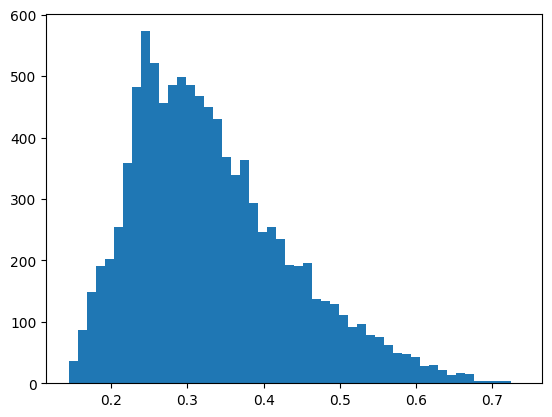

In [0]:
#preds = pd.DataFrame(model.predict([X_train_cat2, X_train_num2]))
preds = pd.DataFrame(preds)
preds.rename(columns={0:'pred_prob'}, inplace=True)
_=plt.hist(preds['pred_prob'].sample(10000), bins=50)

#### Use the conversion balance of the training set to find a reasonable prediction threshold

In [0]:
thresh = np.quantile(preds['pred_prob'], (1-y_train.mean()))
thresh

0.36242879653658183

#### Extract attention weights from their awkward data structure and put them in a dataframe

In [0]:

a2 = []
for i in range(len(attention_weights)):
    a2.append( [attention_weights[i][0][0], attention_weights[i][1][0], attention_weights[i][2][0]])
a2_df = pd.DataFrame(a2, columns=['t1_attn', 't2_attn', 't3_attn'])
a2_df.mean()

t1_attn    0.037672
t2_attn    0.296836
t3_attn    0.665492
dtype: float32

#### Combine original input features, target, actual channel contributions, predictions, and estimated channel attentions in one convenient dataframe

In [0]:

preds_df = pd.concat([preds, pd.DataFrame(y_test)], axis=1)
preds_df.rename(columns={0:'actual'}, inplace=True)
preds_df.reset_index(drop=True,inplace=True)
preds_df['pred'] = preds_df['pred_prob']>thresh
preds_df2 = pd.concat([pd.DataFrame(X_test).reset_index(), preds_df], axis=1)
preds_df2 = pd.concat([preds_df2, a2_df], axis=1)
preds_df3 = preds_df2.merge(df[['t1', 't2', 'gender', 'gap1','cont_fb','cont_gg','cont_sp' ]], 'left', on=['t1', 't2', 'gender', 'gap1'])




#### Functions for getting the contribution for the timestep to compare directly to attention weights

In [0]:
def get_t1_cont(row):
    t1_cont = 0

    if row['t1']==0:
        t1_cont = row['cont_fb']
    elif row['t1']==1:
        t1_cont = row['cont_gg']
    else:
        t1_cont = row['cont_sp']

    return t1_cont

def get_t2_cont(row):
    t2_cont = 0

    if row['t2']==0:
        t2_cont = row['cont_fb']
    elif row['t2']==1:
        t2_cont = row['cont_gg']
    else:
        t2_cont = row['cont_sp']

    return t2_cont

def get_t3_cont(row):
    t3_cont = 0

    if row['t3']==0:
        t3_cont = row['cont_fb']
    elif row['t3']==1:
        t3_cont = row['cont_gg']
    else:
        t3_cont = row['cont_sp']

    return t3_cont

In [0]:
preds_df3['t1_cont'] = preds_df3.apply(get_t1_cont, axis=1)
preds_df3['t2_cont'] = preds_df3.apply(get_t2_cont, axis=1)
preds_df3['t3_cont'] = preds_df3.apply(get_t3_cont, axis=1)

#### Preview a sample of estimated attention (t1_attn, t2_atten) *vs.* actual contribution (t1_cont, t2_cont)

### combine attention for time steps that have the same channel

In [0]:
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t1']!=preds_df3['t3']), 't1_attn'] = preds_df3['t1_attn']+preds_df3['t2_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t1']!=preds_df3['t3']), 't2_attn'] = preds_df3['t1_attn']

preds_df3.loc[(preds_df3['t1']==preds_df3['t3']) & (preds_df3['t1']!=preds_df3['t2']), 't1_attn'] = preds_df3['t1_attn']+preds_df3['t3_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t3']) & (preds_df3['t1']!=preds_df3['t2']), 't3_attn'] = preds_df3['t1_attn']

preds_df3.loc[(preds_df3['t2']==preds_df3['t3']) & (preds_df3['t2']!=preds_df3['t1']), 't2_attn'] = preds_df3['t2_attn']+preds_df3['t3_attn']
preds_df3.loc[(preds_df3['t2']==preds_df3['t3']) & (preds_df3['t2']!=preds_df3['t1']), 't3_attn'] = preds_df3['t2_attn']

preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t2']==preds_df3['t3']), 't1_attn'] = preds_df3['t1_attn']+preds_df3['t2_attn']+preds_df3['t3_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t2']==preds_df3['t3']), 't2_attn'] = preds_df3['t1_attn']
preds_df3.loc[(preds_df3['t1']==preds_df3['t2']) & (preds_df3['t2']==preds_df3['t3']), 't23attn'] = preds_df3['t1_attn']


In [0]:
preds_df3[(preds_df3['actual']==1) & ((preds_df3['t2']!=preds_df3['t3']) | (preds_df3['t1']!=preds_df3['t2']))][['t1', 't2', 't3','t1_cont', 't1_attn', 't2_cont', 't2_attn', 't3_cont','t3_attn']].sample(10)


,t1,t2,t3,t1_cont,t1_attn,t2_cont,t2_attn,t3_cont,t3_attn
4685,1,2,0,0.253928,0.039421,0.369297,0.690264,0.376775,0.270315
27021,1,1,2,0.515037,0.475498,0.515037,0.475498,0.484963,0.524502
19064,1,1,0,0.296854,0.246706,0.296854,0.246706,0.703146,0.753294
19904,0,0,2,0.210136,0.143769,0.210136,0.143769,0.789864,0.856231
9082,0,2,0,0.634207,0.799557,0.365793,0.200443,0.634207,0.799557
9324,0,2,1,0.034684,0.026192,0.461263,0.215293,0.504053,0.758515
13477,1,0,2,0.105561,0.034787,0.244189,0.271828,0.650250,0.693385
5121,0,1,0,0.680723,0.681552,0.319277,0.318448,0.680723,0.681552
4861,1,0,0,0.129970,0.044516,0.870030,0.955484,0.870030,0.955484
25017,2,1,0,0.240458,0.030615,0.137662,0.205483,0.621880,0.763902


### Distribution of actual T1 attribution

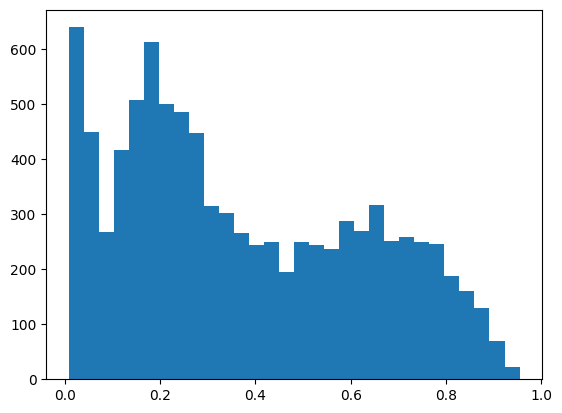

In [0]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & ((preds_df3['t2']!=preds_df3['t3']) | (preds_df3['t1']!=preds_df3['t2']))]['t1_cont'], bins=30)


### Plot Estimated Attribution vs. Actual Attribution

In [0]:
preds_df3 = preds_df3[(preds_df3['t1']!=preds_df3['t2']) | (preds_df3['t1']!=preds_df3['t3'])] 
preds_df3 = preds_df3[(preds_df3['actual']==1)]

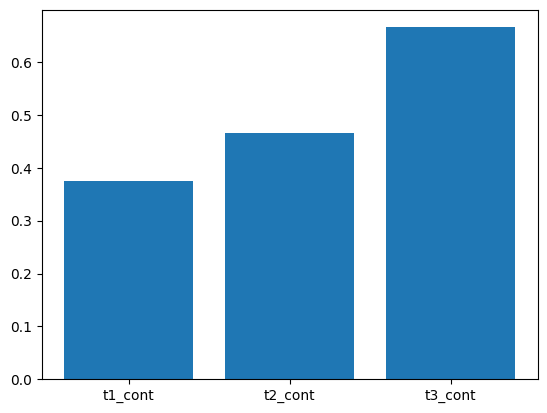

In [0]:
_=plt.bar(['t1_cont', 't2_cont', 't3_cont'],preds_df3[['t1_cont', 't2_cont', 't3_cont']].mean())


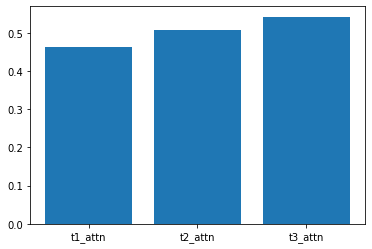

In [0]:
_=plt.bar(['t1_attn', 't2_attn', 't3_attn'],preds_df3[['t1_attn', 't2_attn', 't3_attn']].mean())


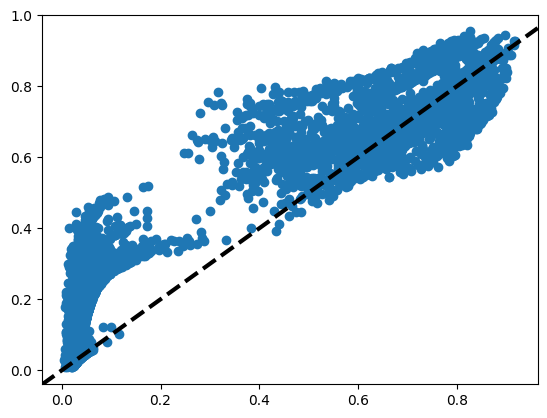

In [0]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t1_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t1_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

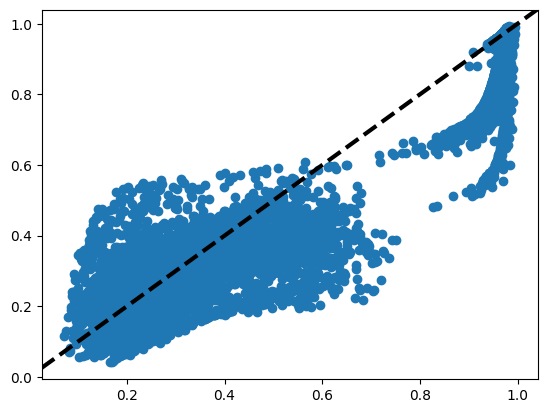

In [0]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t2_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t2_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

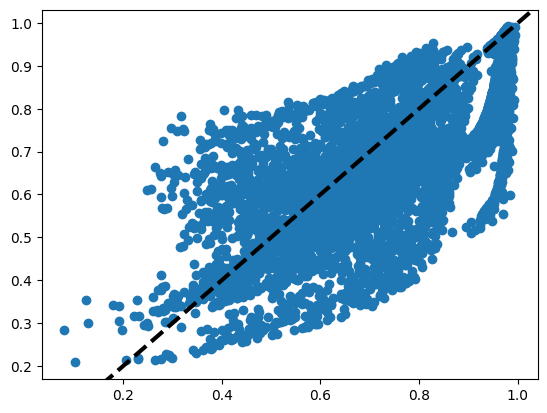

In [0]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t3_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t3_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

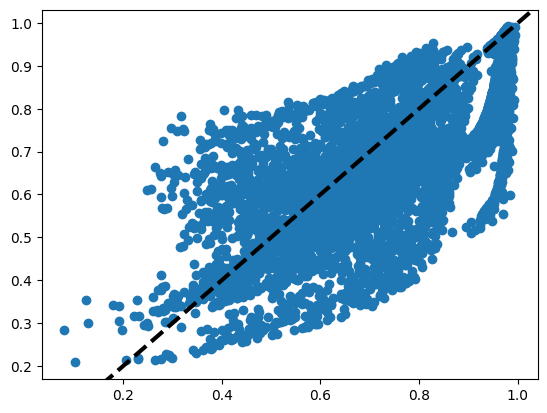

In [0]:
plt.scatter(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t3_attn'], preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2'])]['t3_cont'])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

### Calculate residuals for the DLAW model and 3 naive models: 50/50 split, last touched, and first touched

In [0]:
#preds_df3['cont_error'] = ( abs(preds_df3['t1_cont']-preds_df3['t1_attn'])+abs(preds_df3['t2_cont']-preds_df3['t2_attn']) ) / (num_time_steps-1)
preds_df3['cont_error'] = ( abs(preds_df3['t1_cont']-preds_df3['t1_attn'])+abs(preds_df3['t2_cont']-preds_df3['t2_attn'])+abs(preds_df3['t3_cont']-preds_df3['t3_attn']) ) / num_time_steps
preds_df3['5050_cont_error'] = (abs(preds_df3['t1_cont']-(1/num_time_steps)) + abs(preds_df3['t2_cont']-(1/num_time_steps)) +abs(preds_df3['t3_cont']-(1/num_time_steps)) ) / num_time_steps
preds_df3['last_touch_cont_error'] = 1-preds_df3['t3_cont']
preds_df3['first_touch_cont_error'] = 1-preds_df3['t1_cont']
#preds_df3 = preds_df3[preds_df3['t1']!=preds_df3['t2']]

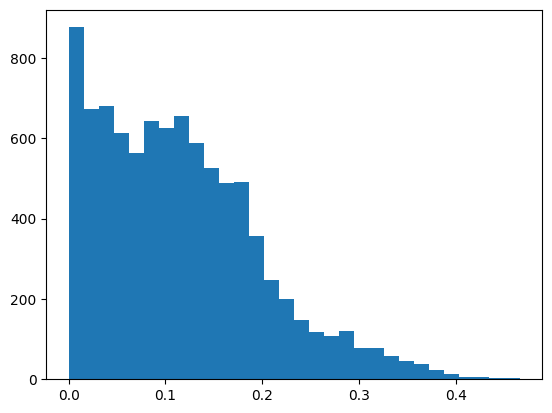

In [0]:
_=plt.hist(preds_df3['cont_error'], bins=30)

(array([ 878., 1325.,  603.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

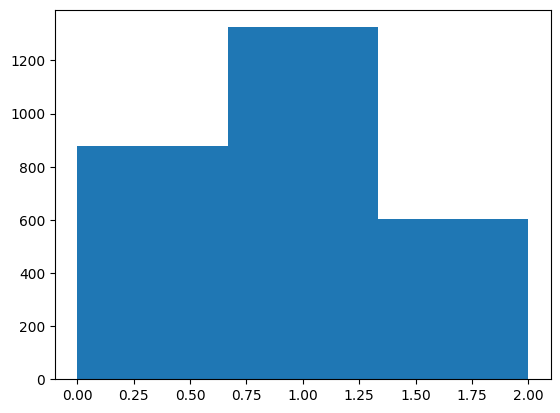

In [0]:
lg_err = preds_df3[np.sqrt(preds_df3['cont_error']**2)>.15]
sm_err = preds_df3[np.sqrt(preds_df3['cont_error']**2)<=.1]

plt.hist(lg_err['t3'], bins=3)

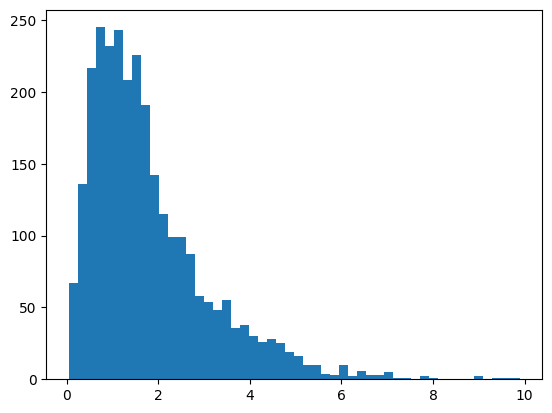

In [0]:
_=plt.hist(lg_err['gap1'], bins=50)

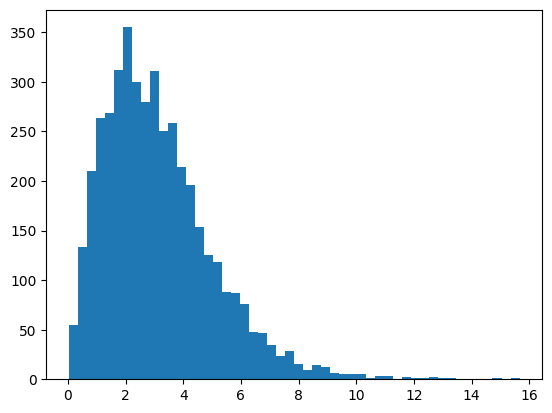

In [0]:
_=plt.hist(sm_err['gap1'], bins=50)

### Calculate MAE only for observations with:
 - actual conversion==1: we only care about attributing people who converted
 - t1 channel does not equal t2 channel: there is no uncertainty of attribution in cases where t1 channel==t2 channel
 - predicted probability >0.03: These are likely noisier since the model found no signal for conversion. This was chosen arbitrarily ahead of time and does not change for each run

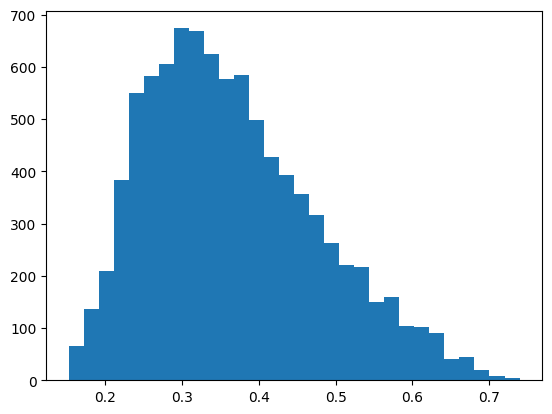

In [0]:
_=plt.hist(preds_df3['pred_prob'], bins=30)

In [0]:
min_p = .03
print('pct obs over min_p:', round(len(preds_df3[preds_df3['pred_prob']>min_p])/len(preds_df3), 3 ) )

pct obs over min_p: 1.0


### Predicted prob and the DLAW error is strongly negatively correlated indicating more certainty with higher predictions of conversion.

Corr between predicted prob and magnitude of DLAW error: -0.4521
Corr between predicted magnitude of t1_attn and magnitude of DLAW error: -0.125


In [0]:
dlaw_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).mean()
dlaw_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).median()
dlaw_err_sd = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['cont_error'].apply(lambda x: abs(x)).std()
dlaw_95CI = dlaw_mae+(1.64*dlaw_err_sd)

even_split_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).mean()
even_split_medae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).median()
even_split_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'].apply(lambda x: abs(x)).std()
even_split_95CI = even_split_mae+(1.64*even_split_err_sd)


lt_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).mean()
lt_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).median()
lt_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'].apply(lambda x: abs(x)).std()
lt_95CI = lt_mae+(1.64*lt_err_sd)


ft_mae = preds_df3[(preds_df3['actual']==1)  & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).mean()
ft_medae = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).median()
ft_err_sd = preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'].apply(lambda x: abs(x)).std()
ft_95CI = ft_mae+(1.64*ft_err_sd)




print('DLAW Stats:\n', 'Mean AE:', round(dlaw_mae, 3),', SD AE:',round(dlaw_err_sd, 3), ', Median AE', round(dlaw_medae, 3), '95% CI Error:', round(dlaw_95CI, 3))
print('\n50/50 Split Stats:\n', 'Mean AE:', round(even_split_mae, 3), ', Median AE', round(even_split_medae, 3), '95% CI Error:', round(even_split_95CI, 3))
print('\nLast Touched Stats:\n', 'Mean AE:', round(lt_mae, 3), ', Median AE', round(lt_medae, 3), '95% CI Error:', round(lt_95CI, 3))
print('\nFirst Touched Stats:\n', 'Mean AE:', round(ft_mae, 3), ', Median AE', round(ft_medae, 3), '95% CI Error:', round(ft_95CI, 3))




DLAW Stats:
 Mean AE: 0.116 , SD AE: 0.084 , Median AE 0.105 95% CI Error: 0.253

50/50 Split Stats:
 Mean AE: 0.256 , Median AE 0.22 95% CI Error: 0.458

Last Touched Stats:
 Mean AE: 0.334 , Median AE 0.327 95% CI Error: 0.616

First Touched Stats:
 Mean AE: 0.625 , Median AE 0.687 95% CI Error: 1.042


In [0]:
preds_df3.columns

Index(['index', 't1', 't2', 't3', 'gender', 'gap1', 'log_gap1', 'gender_t2',
       'gap2', 'log_gap2', 'gender_t3', 'gap3', 'log_gap3', 'epsilon',
       'pred_prob', 'actual', 'pred', 't1_attn_unscaled', 't2_attn_unscaled',
       't3_attn_unscaled', 'cont_fb', 'cont_gg', 'cont_sp', 't1_attn',
       't2_attn', 't3_attn', 't1_cont', 't2_cont', 't3_cont', 't23attn',
       'cont_error', '5050_cont_error', 'last_touch_cont_error',
       'first_touch_cont_error'],
      dtype='object')

#### DLAW Distribution of Residuals

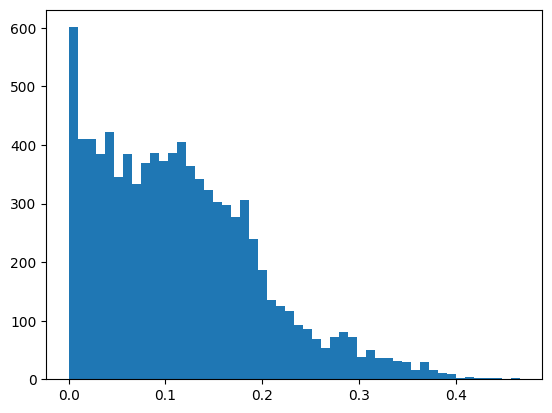

In [0]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['pred_prob']>min_p)]['cont_error'], bins=50)


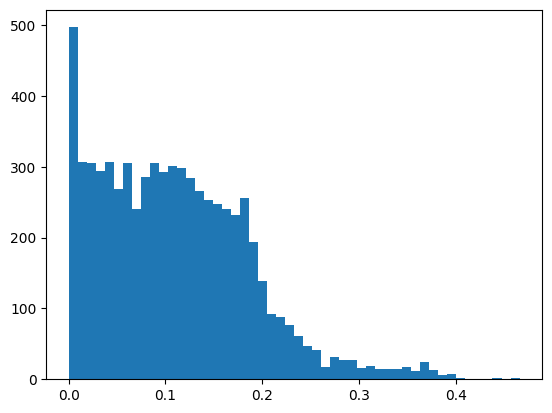

In [0]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['cont_error'], bins=50)


#### 50/50 Split Distribution of Residuals

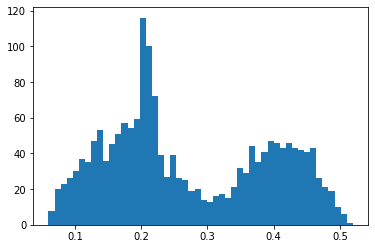

In [0]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['5050_cont_error'], bins=50)


#### Last Touched Distribution of Residuals

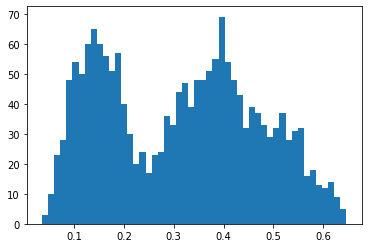

In [0]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['last_touch_cont_error'], bins=50)


#### First Touched Distribution of Residuals

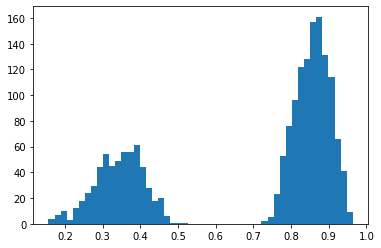

In [0]:
_=plt.hist(preds_df3[(preds_df3['actual']==1) & (preds_df3['t1']!=preds_df3['t2']) & (preds_df3['pred_prob']>min_p)]['first_touch_cont_error'], bins=50)


## Impact of Noise on the Model

### Distribution of error in False Positives is left skewed as expected. 
##### The model made the right inference of "Likely Conversion" based solely on the inputs available to it onaverage,but was screwed from the get go due to the large, negative error that ended up with the majority of impact in determining the actual conversion status

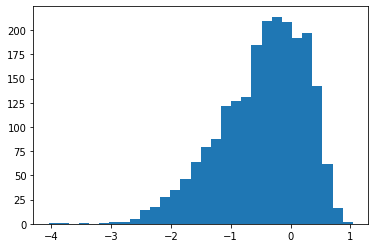

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['epsilon'], bins=30)

### Distribution of error in True Positives is more symmetrical and centered closer to zero


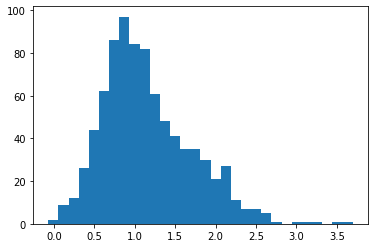

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==True)]['epsilon'], bins=30)

### Distribution of error in False Negatives is right skewed as expected


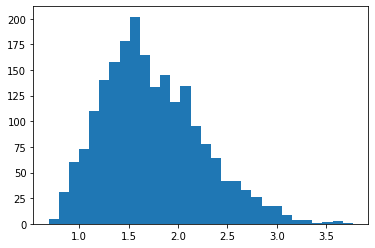

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['epsilon'], bins=30)

### Distribution of error in True Negatives is more symmetrical and centered closer to zero


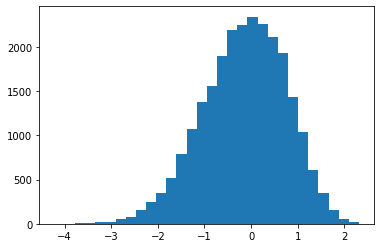

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==False)]['epsilon'], bins=30)

### In the cases of False Positive and False Negative: the model made the right inference of "Likely Conversion" or "Unlikely Conversion", respectively, based solely on the inputs available to it on average.
### However it was screwed from the get go due to the large, negative or positive error, respectively, that ended up with the majority of impact in determining the actual conversion status

# Accuracy of Y Prediction
### *This is secondary to the main purpose of the model which is to learn attribution percentages, and is mostly unimportant given the simplicity of the DGP in the simulation. However, a model with better performance is more likely to specify the parameters correctly so improving the prediction accuracy can be expected to improve attribution accuracy as well.

In [0]:
from sklearn.metrics import precision_score, recall_score

In [0]:
conf = confusion_matrix(preds_df2['actual'], preds_df2['pred'])
conf = pd.DataFrame(conf)
conf.rename(columns={0:'pred_False', 1:'pred_True'}, inplace=True)
print('Test Accuracy:', accuracy_score(preds_df2['actual'], preds_df2['pred']))
print('Test Precision:', precision_score(preds_df2['actual'], preds_df2['pred']))
print('Test Recall:', recall_score(preds_df2['actual'], preds_df2['pred']))
conf

Test Accuracy: 0.8572
Test Precision: 0.2764764104256021
Test Recall: 0.2861044725162171


,pred_False,pred_True
0,24878,2193
1,2091,838


## Error Distributions Correlations with Features

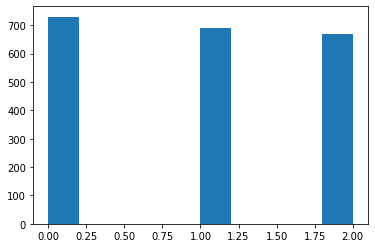

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t2'])

### False positives appear to be worse for Google (1) in T1 and Facebook (0) in T2

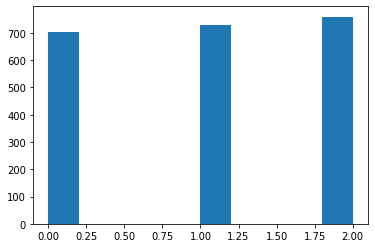

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['t1'])

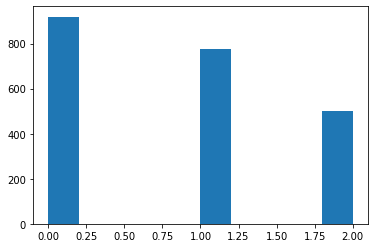

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['t2'])

### False Negatives appear to be worse for Facebook (0) in T2

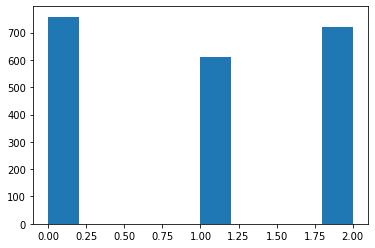

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t1'])

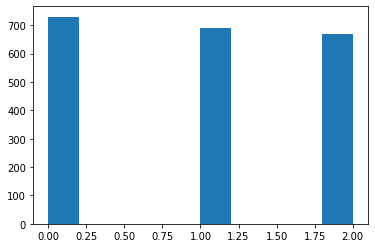

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['t2'])

### Elapsed time (gap1) distribution for False Negative

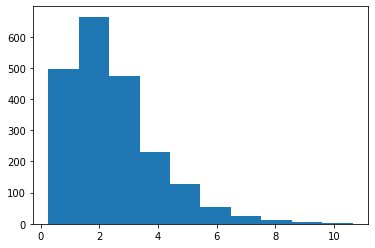

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==1) & (preds_df2['pred']==False)]['gap1'])

### Elapsed time (gap1) distribution for False Positive

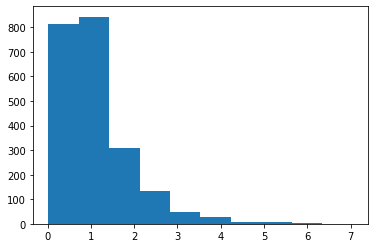

In [0]:
_=plt.hist(preds_df2[(preds_df2['actual']==0) & (preds_df2['pred']==True)]['gap1'])
